In [78]:
import csv
import os

import math
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

from lime.lime_tabular import LimeTabularExplainer
import shap

# Load Data

In [2]:
# load y data
participant_info_df = pd.read_csv("../Model_Input/participant_info.csv")
participant_info_df.sort_values('id', inplace=True) #make sure, its alphabetically sorted

participants = participant_info_df.set_index('id')['ASC'].to_dict()

# rename participant ids to their corresponding dataframe name
#for k in list(participants.keys()):
#    new_key = k + "_concat.csv"
#    participants[new_key] = participants.pop(k)

In [3]:
# Define the mapping for renaming
rename_map = {
    'neutral_participant': 'np',
    'neu_actress': 'na',
    'joy_participant': 'jp',
    'joy_actress': 'ja',
    'disgust_participant': 'dp',
    'disgust_actress': 'da'
}
        

In [4]:
# Load X Data
method_frames = {}

for root, dirs, files in os.walk("../Model_Input/parted_video"):
    for f in files:
        if ".csv" in f:
            path = os.path.join(root, f)
            df = pd.read_csv(path, header=[0, 1])
            
            # Rename the columns using a renaming map
            df.rename(columns=rename_map, inplace=True)

            # Create a new column with the concatenated first and second row
            df.columns = ['_'.join(filter(None, col)).strip() for col in df.columns]
            # Rename the first column to 'id'
            df.columns.values[0] = 'id'

            # drop
            # Get rid of unknown participant
            df = df.drop(df[df['id'] == 'pre-91-020_part_1_concat.csv'].index)
            df = df.drop([col for col in df.columns if '_median' in col], axis=1)
            
            method_frames[f] = df


print(method_frames.keys())

dict_keys(['libreface_stats_parted.csv', 'me_graph_stats_parted.csv', 'openframe_stats_parted.csv', 'libreface_stats_parted-checkpoint.csv'])


In [80]:
method_frames["me_graph_stats_parted.csv"].columns

Index(['id', 'AU1_mean_na', 'AU2_mean_na', 'AU4_mean_na', 'AU5_mean_na',
       'AU6_mean_na', 'AU7_mean_na', 'AU9_mean_na', 'AU10_mean_na',
       'AU11_mean_na',
       ...
       'AU20_var_dp', 'AU22_var_dp', 'AU23_var_dp', 'AU24_var_dp',
       'AU25_var_dp', 'AU26_var_dp', 'AU27_var_dp', 'AU32_var_dp',
       'AU38_var_dp', 'AU39_var_dp'],
      dtype='object', length=487)

In [6]:
def test_label_correctness(data):
    # Test if participant labels are correct with data:
    zipped = zip(list(data["id"]), list(participants.keys()))
    for l1,l2 in zipped:
        if not l2 in l1:
            print(f"{l1} != {l2}")

def clean_data(method_name):
    df = method_frames[method_name]
    
    # make sure it's sorted by participant in alph. order
    df = df.sort_values("id")

    print(method_name)
    test_label_correctness(df)

    # Reset the index to ensure it's numerical
    df = df.drop(columns='id').reset_index(drop=True)

    
    return df

In [7]:
OF = clean_data("openframe_stats_parted.csv")

openframe_stats_parted.csv


In [8]:
LF = clean_data('libreface_stats_parted.csv')

libreface_stats_parted.csv


In [9]:
ME = clean_data('me_graph_stats_parted.csv')

me_graph_stats_parted.csv


# SHAP

In [10]:
def shap_training(X, y):

    loo = LeaveOneOut()
    y_true = []
    y_scores = []
    shap_values_list = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train your model
        model = XGBClassifier()
        model.fit(X_train, y_train)
        
        # Get the predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
    
        y_true.append(y_test[0])
        y_scores.append(y_score[0])
        
        # Explain the model's predictions using SHAP values
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        shap_values_list.append(shap_values)

   
    return y_true, y_scores, shap_values_list

In [11]:
def show_shap(shap_prediction, index=0):
    # Combine SHAP values from all LOOCV iterations
    shap_values_list = shap_prediction[2]
    combined_shap_values = np.concatenate([sv.values for sv in shap_values_list])
    
    predicted = shap_prediction[0][index]
    score = shap_prediction[1][index]
    true_label = labels[index]

    shap_result = shap_values_list[index][0]

    print(f"predicted: {predicted}, true: {true_label}, score: {score}")
    # Visualize the SHAP values for the first prediction
    shap.plots.waterfall(shap_result)

In [12]:
labels = np.array(list(participants.values()))

## Apply on Openface

In [13]:
OF_results = shap_training(OF, labels)

Show result for one example (the number is the index of an example)

predicted: 1, true: 1, score: 0.6928392052650452


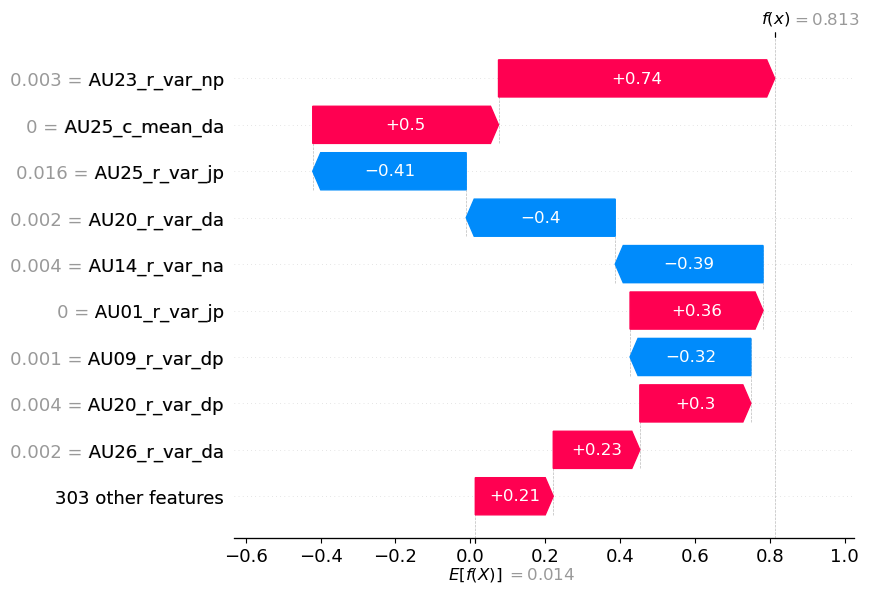

In [14]:
show_shap(OF_results, 3)

In [15]:
shap_values = np.array(OF_results[2])
print( shap_values.shape )

(164, 1, 312)


### SHAP summary plot (Openface)

In [16]:
# Combine SHAP values for all instances
shap_values_list = OF_results[2]
shap_values_combined = shap_values_list.copy()[0]
for shap_values in shap_values_list[1:]:
    shap_values_combined.values = np.vstack((shap_values_combined.values, shap_values.values))

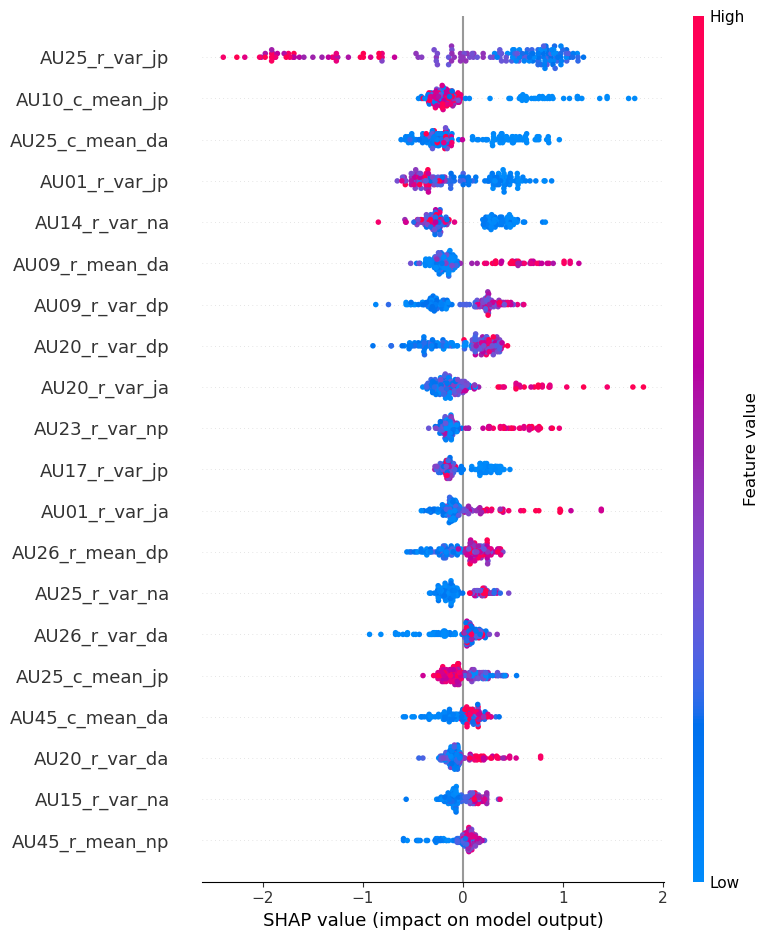

In [17]:
# Plot summary plot
shap.summary_plot(shap_values_combined, OF, show=False)

# Save the plot as a file
plt.savefig('shap_summary_plot_Openface.png')

plt.show()

## Apply on Openface (intensity only)

In [31]:
# reduce data to intensity
OF_i = OF.filter(like='_r')
print(OF_i.columns)

Index(['AU01_r_mean_na', 'AU02_r_mean_na', 'AU04_r_mean_na', 'AU05_r_mean_na',
       'AU06_r_mean_na', 'AU07_r_mean_na', 'AU09_r_mean_na', 'AU10_r_mean_na',
       'AU12_r_mean_na', 'AU14_r_mean_na',
       ...
       'AU10_r_var_dp', 'AU12_r_var_dp', 'AU14_r_var_dp', 'AU15_r_var_dp',
       'AU17_r_var_dp', 'AU20_r_var_dp', 'AU23_r_var_dp', 'AU25_r_var_dp',
       'AU26_r_var_dp', 'AU45_r_var_dp'],
      dtype='object', length=204)


In [32]:
OF_results_i = shap_training(OF_i, labels)

Show result for one example (the number is the index of an example)

In [33]:
# Combine SHAP values for all instances
shap_values_list = OF_results_i[2]
shap_values_combined = shap_values_list.copy()[0]
for shap_values in shap_values_list[1:]:
    shap_values_combined.values = np.vstack((shap_values_combined.values, shap_values.values))

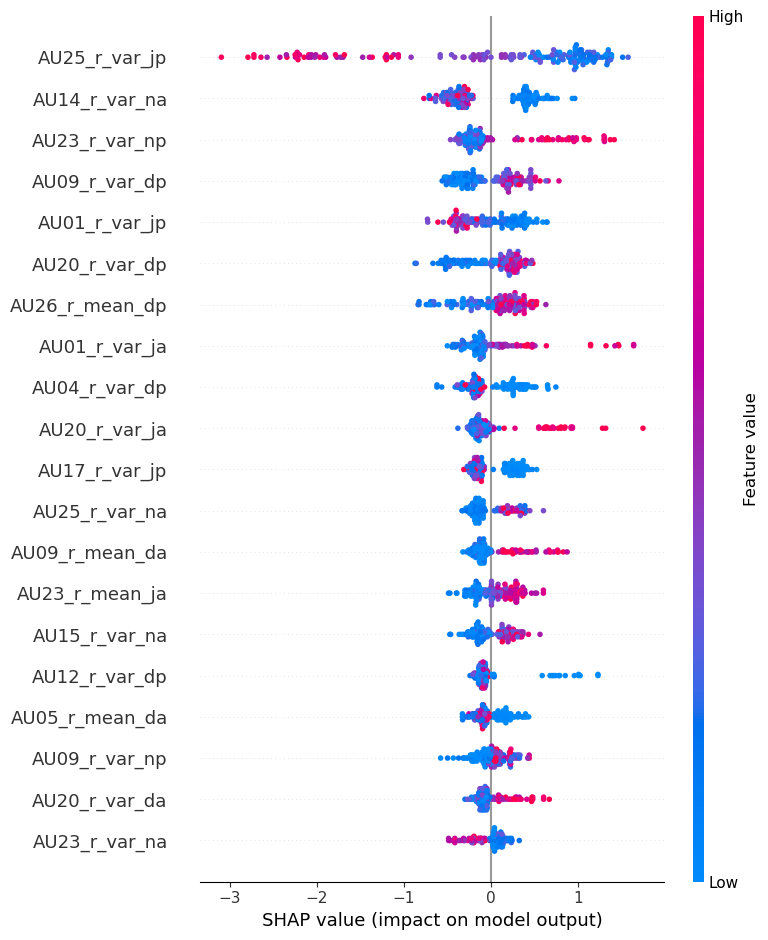

In [34]:
# Plot summary plot
shap.summary_plot(shap_values_combined, OF_i, show=False)

# Save the plot as a file
plt.savefig('shap_summary_plot_Openface_intensity.png')

plt.show()

## Apply on Libreface

In [18]:
LF_results = shap_training(LF, labels)

Show result for one example (the number is the index of an example)

predicted: 1, true: 1, score: 0.6620970368385315


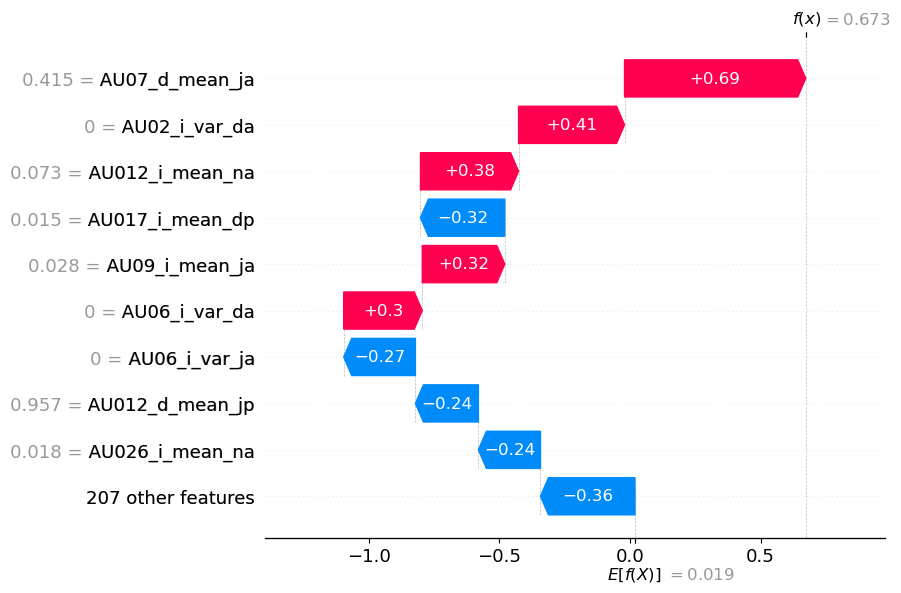

In [19]:
show_shap(LF_results, 3)

### SHAP summary plot (Libreface)

In [20]:
# Combine SHAP values for all instances
shap_values_list = LF_results[2]
shap_values_combined = shap_values_list.copy()[0]
for shap_values in shap_values_list[1:]:
    shap_values_combined.values = np.vstack((shap_values_combined.values, shap_values.values))

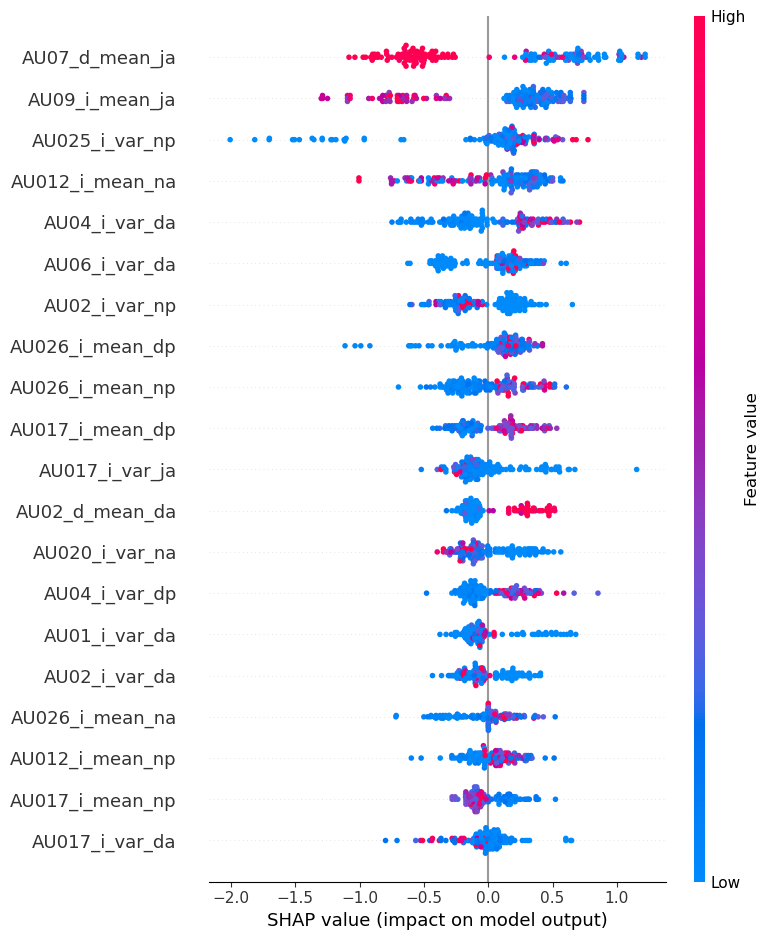

In [21]:
# Plot summary plot
shap.summary_plot(shap_values_combined, LF, show=False)

# Save the plot as a file
plt.savefig('shap_summary_plot_Libreface.png')

plt.show()

## Apply SHAP on ME-GraphAU

In [22]:
ME_results = shap_training(ME, labels)

predicted: 1, true: 1, score: 0.5908674001693726


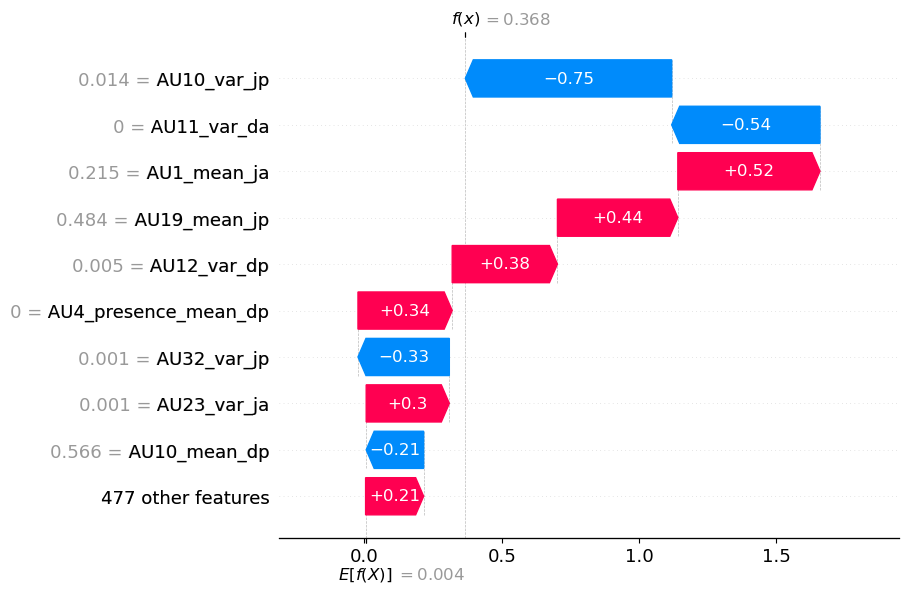

In [23]:
show_shap(ME_results, 3)

### SHAP summary plot (ME-Graph)

In [24]:
# Combine SHAP values for all instances
shap_values_list = ME_results[2]
shap_values_combined = shap_values_list.copy()[0]
for shap_values in shap_values_list[1:]:
    shap_values_combined.values = np.vstack((shap_values_combined.values, shap_values.values))

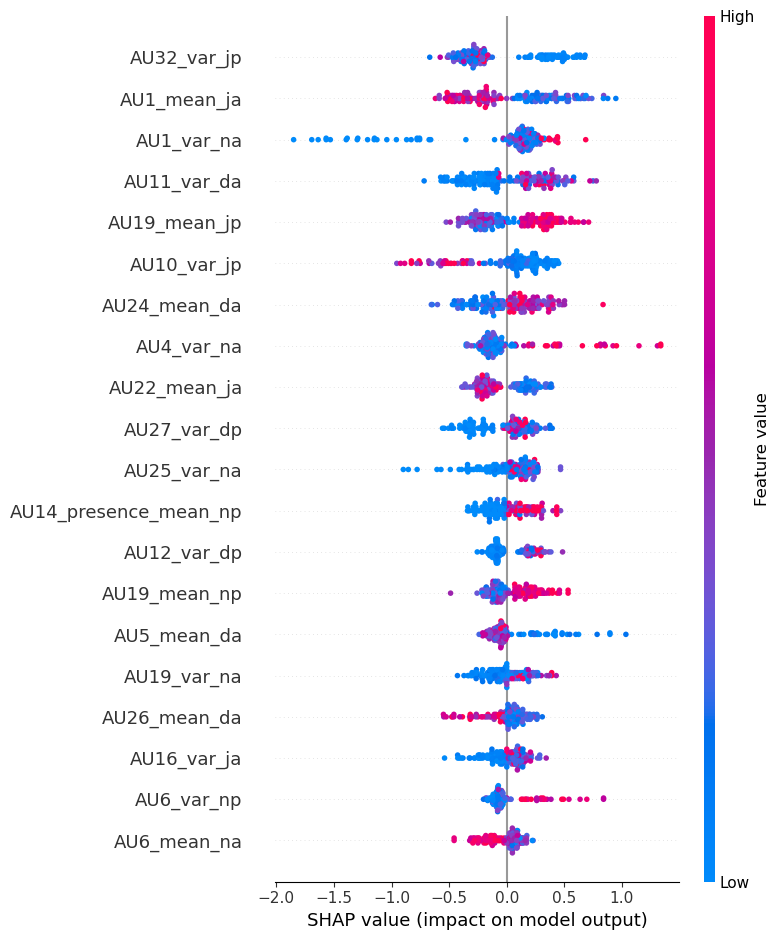

In [25]:
# Plot summary plot
shap.summary_plot(shap_values_combined, ME, show=False)

# Save the plot as a file
plt.savefig('shap_summary_plot_me_graph.png')

plt.show()

In [81]:
cv = LeaveOneOut()
# create model instance
xbst = XGBClassifier() #(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    
# evaluate model
me_loocv_predictions = cross_val_predict(xbst, ME, labels, cv=cv, n_jobs=-1) # 'precision', 'recall'

In [82]:
me_acc = accuracy_score(labels, me_loocv_predictions)
me_prec = precision_score(labels, me_loocv_predictions, average="binary")
me_rec = recall_score(labels, me_loocv_predictions, average="binary")

print(f"ME-Gaph with only {list_AUs}:\nAcc:\t{me_acc}\nPrec:\t{me_prec}\nRecall:\t{me_rec}")

ME-Gaph with only ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']:
Acc:	0.6341463414634146
Prec:	0.6455696202531646
Recall:	0.6144578313253012


## ME-Graph (only basic AUs)

In [70]:
list_AUs = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']

test = [col for col in ME.columns] #if any(substring in col for substring in list_AUs)]

filtered_columns = [col for col in ME.columns if any([col.startswith(au + "_") for au in list_AUs])]
ME_filtered = ME[filtered_columns]

In [66]:
ME_results_au = shap_training(ME_filtered, labels)

In [67]:
# Combine SHAP values for all instances
shap_values_list = ME_results_au[2]
shap_values_combined = shap_values_list.copy()[0]
print(len(shap_values_list))
for shap_values in shap_values_list[1:]:
    shap_values_combined.values = np.vstack((shap_values_combined.values, shap_values.values))

164


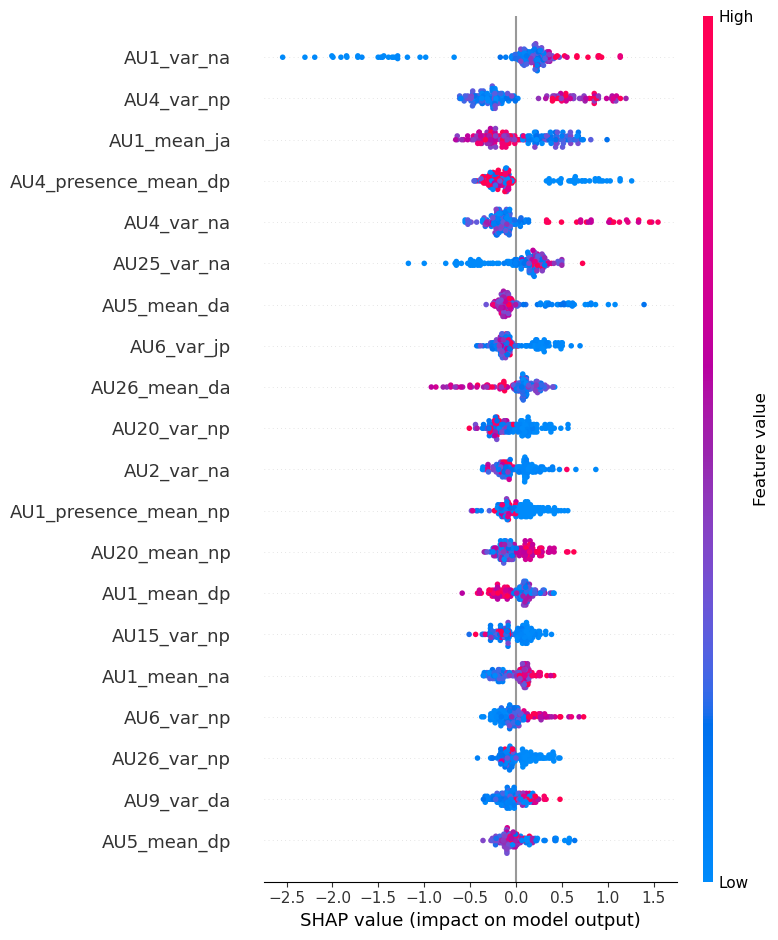

In [68]:
# Plot summary plot
shap.summary_plot(shap_values_combined, ME_filtered, show=False)

# Save the plot as a file
plt.savefig('shap_summary_plot_me_graph_reduced.png')

plt.show()

In [75]:
cv = LeaveOneOut()
# create model instance
xbst = XGBClassifier() #(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    
# evaluate model
me_loocv_filtered_predictions = cross_val_predict(xbst, ME_filtered, labels, cv=cv, n_jobs=-1) # 'precision', 'recall'

In [79]:
me_acc = accuracy_score(labels, me_loocv_filtered_predictions)
me_prec = precision_score(labels, me_loocv_filtered_predictions, average="binary")
me_rec = recall_score(labels, me_loocv_filtered_predictions, average="binary")

print(f"ME-Gaph with only {list_AUs}:\nAcc:\t{me_acc}\nPrec:\t{me_prec}\nRecall:\t{me_rec}")

ME-Gaph with only ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']:
Acc:	0.6341463414634146
Prec:	0.632183908045977
Recall:	0.6626506024096386
